In [1]:
# CS510: Computer Vision and Deep Learning
# Final Group Project: Haadiya Ansari, Austen Hsiao, John Strenio
# Professor Rhodes
# Citations: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
#            https://www.mydatahack.com/building-alexnet-with-keras/
# Summary: 
#   This program is designed to perform experiments on The Alexnet Model
#   and its use in the classification of pneumonia xrays, specifically to find 
#   the effect of image size on the model's performance. The program can be 
#   run as a whole as is granted the dataset cited above is in the working
#   directory. It will begin with model training.


In [2]:
# This cell builds the Alexnet Model, processes the dataset, and trains the model
from keras import layers
from keras import preprocessing
from keras import models
from keras import optimizers
import cv2
import numpy as np

# Initialize and create the CNN
TRAINING_PATH = 'chest_xray/train'
TESTING_PATH = 'chest_xray/test'
TARGET_SIZE = (200, 200)
INPUT_SHAPE = (200, 200, 3)

classifier = models.Sequential()
classifier.add(layers.Convolution2D(96, (11, 11), strides = 4, input_shape = INPUT_SHAPE, activation = 'relu'))
classifier.add(layers.BatchNormalization())
classifier.add(layers.MaxPooling2D(pool_size = (3,3), strides = 2))
classifier.add(layers.Convolution2D(256, (5, 5), padding = 'same', activation = 'relu'))
classifier.add(layers.BatchNormalization())
classifier.add(layers.MaxPooling2D(pool_size = (3,3), strides = 2))
classifier.add(layers.Convolution2D(384, (3, 3), activation = 'relu'))
classifier.add(layers.Convolution2D(384, (3, 3), activation = 'relu'))
classifier.add(layers.Convolution2D(256, (3, 3), activation = 'relu'))
classifier.add(layers.MaxPooling2D(pool_size = (3,3), strides = 2))

classifier.add(layers.Flatten())

classifier.add(layers.Dense(4096, activation = 'relu'))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(4096, activation = 'relu'))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(1000, activation = 'relu'))
classifier.add(layers.Dense(1, activation = 'sigmoid'))

# Compile classifier
opt = optimizers.Adam(learning_rate=0.0001)
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting CNN to the images
train_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                       zoom_range=0.1,
                                                       horizontal_flip=True,
                                                       width_shift_range=[-5,5], 
                                                       height_shift_range=[-5,5], 
                                                       rotation_range=3,
                                                       brightness_range=[0.9,1.1])
test_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                       zoom_range=0.1,
                                                       horizontal_flip=True,
                                                       width_shift_range=[-5,5], 
                                                       height_shift_range=[-5,5], 
                                                       rotation_range=3,
                                                       brightness_range=[0.9,1.1])
training_set = train_datagen.flow_from_directory(TRAINING_PATH, target_size=TARGET_SIZE, batch_size=32, class_mode='binary')
test_set = test_datagen.flow_from_directory(TESTING_PATH, target_size=TARGET_SIZE, batch_size=32, class_mode='binary')
#classifier.fit_generator(training_set, steps_per_epoch=5216/32, epochs=25, validation_data=test_set, validation_steps = 624/32)



Found 5216 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [3]:
# This cell prints a summary of the model and saves it

#  find the last layer conv layer by name from the summary
# save the model (comment out unless using)
classifier.summary()
#classifier.save('saved_model_08') 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         8

In [4]:
# This cell defines a function for preprocessing an image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import PIL

# function for prepping an individual image for prediction
def preprocess_image(img):
    raw_img = cv2.imread(img)
    orig_size = raw_img.shape
    raw_img = cv2.resize(raw_img, TARGET_SIZE)
    np_img = np.asarray(raw_img)
    images = list()
    images.append(np_img / 255.0)
    images = np.array(images)
    images = images.reshape(-1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2])
    return images, orig_size 

In [5]:
# load model
classifier = models.load_model('saved_model_07')


In [6]:
# This cell defines the saliency map functions

def build_model_produce_gradients(img, top):
    # build model with same input but with 2 outputs, 1 for the last layer
    last_layer = classifier.get_layer('conv2d_4')
    activations = models.Model([classifier.inputs], [last_layer.output, classifier.output]) 

    # print probabilities of pneumonia or not
    pred = classifier.predict(img)[0][0]
    print('predicted: ' + str(pred))
    class_label = round(pred)

    # track gradients
    with tf.GradientTape() as gtape:
        # run model on image get grads + preds, find grads from last layer to output
        last_layer_out, pred = activations(img)
        loss = pred[0]
        grads = gtape.gradient(loss, last_layer_out)

    return grads, activations, last_layer_out, class_label

def build_map(grads, last_layer_out, orig_size):
    # global avg pooling
    alpha = tf.reduce_mean(grads, axis=[1,2])

    # activation maps x importance
    last_layer_out = np.transpose(last_layer_out[0])
    sal_map = np.tensordot(alpha, last_layer_out, axes=1)
    sal_map = tf.keras.activations.relu(sal_map)
    sal_map = np.array(sal_map[0])

    # resize image
    sal_map = cv2.rotate(sal_map, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
    sal_map = cv2.flip(sal_map, flipCode=0)
    sal_map = cv2.resize(sal_map, (orig_size[1], orig_size[0]))

    return sal_map

# input an image location, produce and save a heatmap of the models activations on it
def saliency_map(raw_img, top):
    img, orig_size = preprocess_image(raw_img)
    grads, activations, last_layer_out, class_label = build_model_produce_gradients(img, top)
    img = img[0]
    heatmap = build_map(grads, last_layer_out, orig_size)
    heatmap = cv2.resize(heatmap, TARGET_SIZE)
    heatmap /= np.max(heatmap)
    heatmap = cv2.applyColorMap(np.uint8(abs(255 - (255 * heatmap))), cv2.COLORMAP_JET)
    img = np.uint8(255 * img)
    combo = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
    plt.imshow(combo)

    fig, arr = plt.subplots(1, 1)
    arr.imshow(heatmap)
    plt.savefig(raw_img + '_HM.jpg')

predicted: 0.065630704
predicted: 0.99939877
predicted: 0.9999474
predicted: 0.06756437
predicted: 0.99982977
predicted: 0.9964268
predicted: 0.7271327
predicted: 0.9993495
predicted: 0.9998195
predicted: 0.37478548
predicted: 0.9998214
predicted: 0.99999917


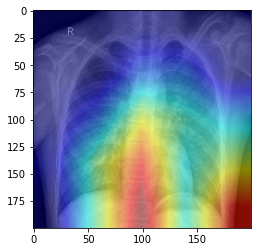

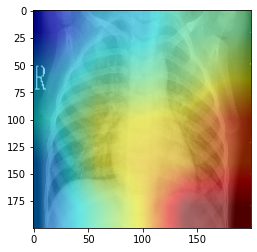

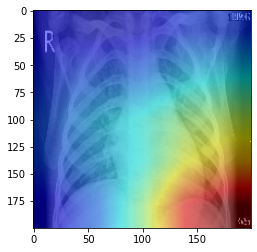

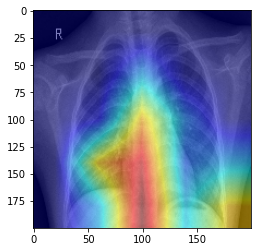

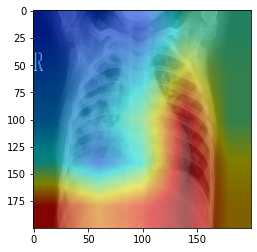

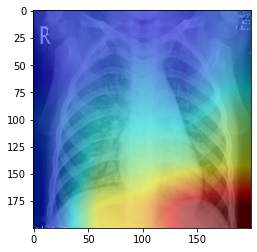

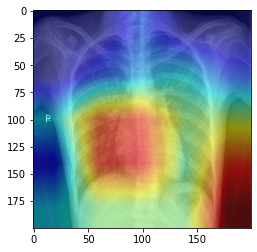

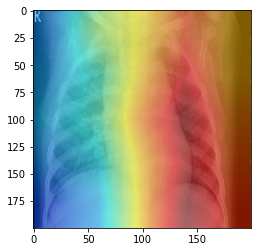

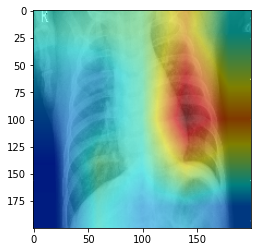

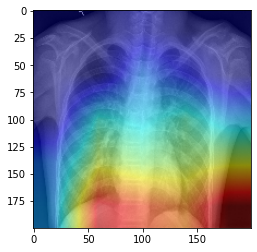

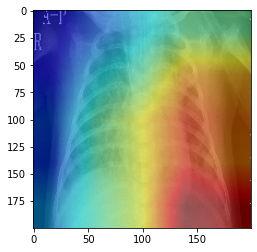

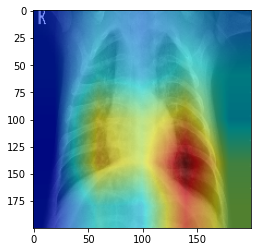

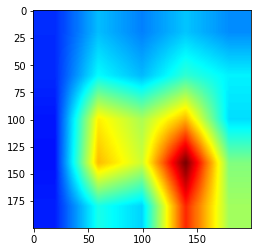

In [16]:
# This cell produces saliency maps for 4 normal, bacterial, and viral chest xrays

norm = []
bact = []
viral = []

# 4 selected images from each category for saliency map for comparison
norm.append(r'chest_xray\test\NORMAL\IM-0011-0001-0001.jpeg')
norm.append(r'chest_xray\test\NORMAL\IM-0023-0001.jpeg')
norm.append(r'chest_xray\test\NORMAL\IM-0028-0001.jpeg')
norm.append(r'chest_xray\test\NORMAL\IM-0011-0001-0002.jpeg')

bact.append(r'chest_xray\val\PNEUMONIA\person1950_bacteria_4881.jpeg')
bact.append(r'chest_xray\val\PNEUMONIA\person1954_bacteria_4886.jpeg')
bact.append(r'chest_xray\val\PNEUMONIA\person1947_bacteria_4876.jpeg')
bact.append(r'chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg')

viral.append(r'chest_xray\test\PNEUMONIA\person62_virus_119.jpeg')
viral.append(r'chest_xray\test\PNEUMONIA\person1672_virus_2888.jpeg')
viral.append(r'chest_xray\test\PNEUMONIA\person1662_virus_2875.jpeg')
viral.append(r'chest_xray\test\PNEUMONIA\person1660_virus_2869.jpeg')

for i in range(len(norm)):
    saliency_map(norm[i], 0)
    saliency_map(bact[i], 0)
    saliency_map(viral[i], 0)


In [17]:
# These cells define the loss and accuracy of their respective image resolution models

# I made the mistake of performing training without saving the loss/acc per epoch so I put these in by hand to avoid 19.5 hours of retraining
# 200x200 training
epochs = [x for x in range(25)]
loss = [.3535, .1666, .1279, .1259, .1197, .1359, .0994, .1007, .1064, .0888, .0968, .0937, .0913, .09, .0785, .0965, .0704, .0738, .0726, .0722, .0705, .0666, .0678, .0795, .0740]
acc = [.8457, .9347, .9470, .9534, .9579, .9497, .9609, .9646, .9604, .9661, .9663, .9643, .9660, .9652, .9716, .9668, .9731, .9722, .9704, .9709, .9727, .9721, .9775, .9729, .9754]
val_loss = [1.68, 3.55, .84, 1.13, 1.99, .75, 1.38, 1.04, .41, .4955, .4087, 1.94, .456, .5767, .4003, .6248, .9258, .358, .58, .4059, .7055, .4357, .5162, .4681, .651]
val_acc = [.625, .625, .649, .6458, .6635, .7516, .6923, .6538, .7756, .8093, .8702, .6955, .7853, .8077, .8638, .7724, .7885, .8526, .8429, .8381, .8013, .8237, .8173, .8494, .8333]

In [9]:
# 400x400 training
epochs = [x for x in range(25)]
acc = [.8364, .9322, .9505, .9488, .9534, .9599, .9632, .9693, .9622, .9630, .9611, .9635, .9597, .9691, .9707, .9727, .9685, .9679, .9721, .9706, .9722, .9763, .9769, .9753, .9761]
val_acc = [.625, .625, .625, .625, .625, .6410, .7212, .6763, .7804, .6378, .7532, .7676, .8846, .8141, .8734, .7676, .7901, .8381, .8109, .7628, .8061, .8397, .8798, .7612, .7484]
loss = [.3688, .1724, .1291, .1421, .1346, .1174, .1026, .0905, .1125, .1015, .0913, .1, .1141, .0910, .0812, .0699, .0825, .0850, .0815, .0724, .0705, .0675, .0658, .0737, .0736]
val_loss = [2.75, 7.15, 4.68, 4.98, 3.56, 1.02, .54, .57, .50, 3.51, .86, .57, .31, .42, .43, .95, .88, .39, .51, .82, .81, .61, .37, 1.28, 1.05]


In [10]:
# 800x800 training
epochs = [x for x in range(15)]
loss = [.70, .16, .16, .15, .12, .13, .12, .1, .1, .11, .09, .09, .09, .09, .07]
acc = [.8005, .9373, .9384, .9469, .9577, .9539, .9551, .9636, .9671, .9607, .9665, .9653, .9682, .9685, .9779]
val_loss = [1.22, 2.81, .52, .48, 1.61, .7454, .4195, .5339, .4777, .9356, .8684, .7076, .6436, .6579, .3597]
val_acc = [.625, .625, .7772, .7548, .6907, .7516, .8077, .7708, .8269, .7901, .6955, .7933, .7035, .7083, .8638]

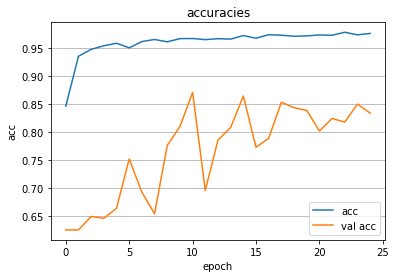

In [18]:
# These cells plot the loss and accuracy of a given model

import matplotlib.pyplot as plt
plt.plot(epochs, acc, label = "acc")
plt.plot(epochs, val_acc, label = "val acc")
plt.xlabel('epoch')
# Set the y axis label of the current axis.
plt.ylabel('acc')
# Set a title of the current axes.
plt.title('accuracies')
# show a legend on the plot
plt.grid(axis = 'y')
plt.legend()
# Display a figure.
plt.show()

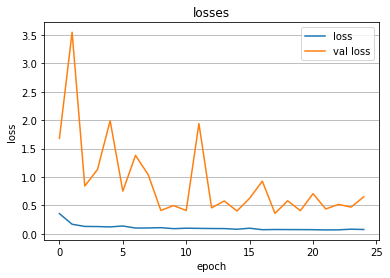

In [19]:
plt.plot(epochs, loss, label = "loss")
plt.plot(epochs, val_loss, label = "val loss")
plt.xlabel('epoch')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# Set a title of the current axes.
plt.title('losses')
# show a legend on the plot
plt.grid(axis = 'y')
plt.legend()
# Display a figure.
plt.show()